In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical 

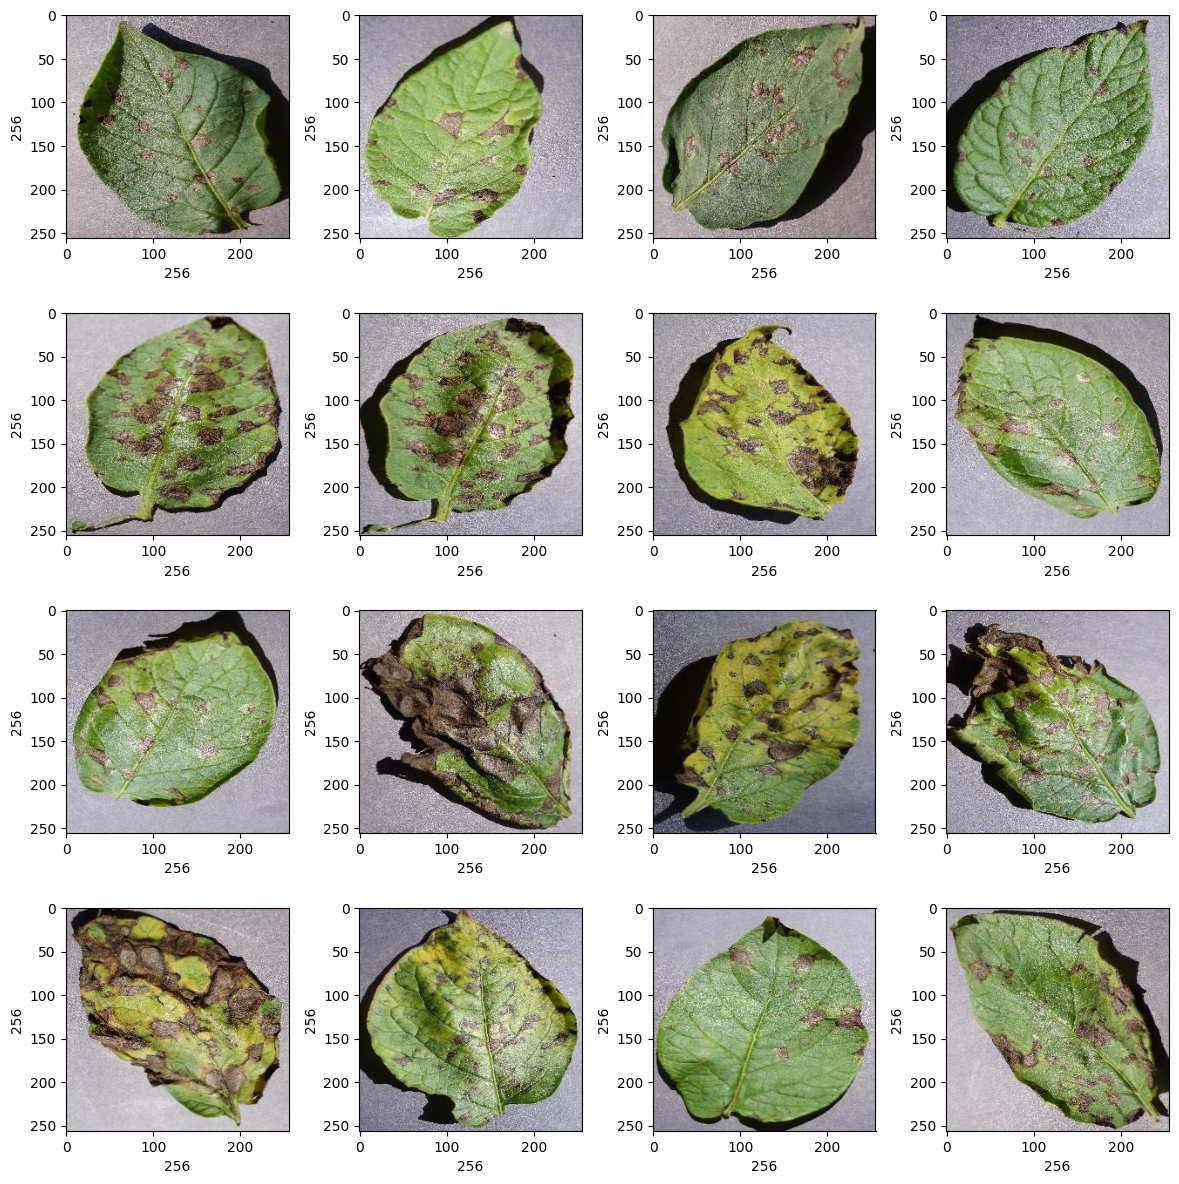

In [4]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "C:\\Users\\ACER\\Downloads\\Yong-MFEC-Intern\\Plant Disease Prediction\\Data\\Plant_images_pianalytix\\Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [5]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # not converting because plant dsieases need to look at colour of leaf 100%
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
import os
from os import listdir
from PIL import Image
import numpy as np
from collections import defaultdict

# Define the root directory containing all plant disease subdirectories
root_dir = "C:\\Users\\ACER\\Downloads\\Yong-MFEC-Intern\\Plant Disease Prediction\\Data\\Plant_images_pianalytix"
sub_dirs = listdir(root_dir)
image_list, label_list = [], []
all_labels = ['Corn_(maize)___Common_rust_', 'Potato___Early_blight', 'Tomato___Bacterial_spot']
binary_labels = [0, 1, 2]
label_map = dict(zip(all_labels, binary_labels))

# Define a dictionary to keep track of the count of images per label
label_counts = defaultdict(int)
max_images_per_label = 300

def convert_image_to_array(image_path):
    try:
        image = Image.open(image_path)
        return np.array(image)
    except Exception as e:
        print(f"Error converting image: {e}")
        return None

# Reading and converting images to numpy arrays
for directory in sub_dirs:
    directory_path = os.path.join(root_dir, directory)
    if os.path.isdir(directory_path):
        plant_image_list = listdir(directory_path)
        label = label_map.get(directory, -1)  # Use -1 for unknown labels
        if label == -1:
            continue
        for file in plant_image_list:
            if label_counts[label] >= max_images_per_label:
                break
            image_path = os.path.join(directory_path, file)
            image_array = convert_image_to_array(image_path)
            if image_array is not None:
                image_list.append(image_array)
                label_list.append(label)
                label_counts[label] += 1

# If you want to see the results
print(f"Total images: {len(image_list)}")
print(f"Label distribution: {label_counts}")

Total images: 900
Label distribution: defaultdict(<class 'int'>, {0: 300, 1: 300, 2: 300})


In [7]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
1    300
2    300
Name: count, dtype: int64

In [8]:
image_list[0].shape

(256, 256, 3)

In [9]:
label_list = np.array(label_list)
label_list.shape

(900,)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [11]:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [12]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('float32').reshape((-1, 1))
y_test = np.asarray(y_test).astype('float32').reshape((-1, 1))

# If you need one-hot encoding (assuming multi-class classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [15]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [20]:
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_val, y_val))


Epoch 1/50
5/5 [==============================] - 9s 2s/step - loss: 0.3418 - accuracy: 0.8976 - val_loss: 0.2830 - val_accuracy: 0.9306
Epoch 2/50
5/5 [==============================] - 8s 2s/step - loss: 0.2167 - accuracy: 0.9566 - val_loss: 0.1972 - val_accuracy: 0.9722
Epoch 3/50
5/5 [==============================] - 7s 1s/step - loss: 0.1427 - accuracy: 0.9705 - val_loss: 0.1884 - val_accuracy: 0.9375
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.1179 - accuracy: 0.9635 - val_loss: 0.1907 - val_accuracy: 0.9236
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 0.1140 - accuracy: 0.9583 - val_loss: 0.1442 - val_accuracy: 0.9583
Epoch 6/50
5/5 [==============================] - 7s 1s/step - loss: 0.0818 - accuracy: 0.9757 - val_loss: 0.1178 - val_accuracy: 0.9653
Epoch 7/50
5/5 [==============================] - 8s 2s/step - loss: 0.0643 - accuracy: 0.9826 - val_loss: 0.1054 - val_accuracy: 0.9861
Epoch 8/50
5/5 [=========================

In [17]:
model.save("C:\\Users\\ACER\\Downloads\\Yong-MFEC-Intern\\Plant Disease Prediction\\plant_disease.h5")
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open("C:\\Users\\ACER\\Downloads\\Yong-MFEC-Intern\\Plant Disease Prediction\\plant_model.json", 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights("C:\\Users\\ACER\\Downloads\\Yong-MFEC-Intern\\Plant Disease Prediction\\plant_model_weights.h5")

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Epoch 1/50
5/5 [==============================] - 9s 2s/step - loss: 0.5597 - accuracy: 0.8611 - val_loss: 0.4578 - val_accuracy: 0.8056
Epoch 2/50


KeyboardInterrupt: 

In [34]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 1s 98ms/step - loss: 0.0289 - accuracy: 0.9944
Test Accuracy: 99.44444298744202


In [35]:
y_pred = model.predict(x_test)

6/6 [==============================] - 1s 122ms/step


In [2]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

NameError: name 'array_to_img' is not defined

In [1]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

NameError: name 'all_labels' is not defined